In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
# !pip show einops

In [44]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F


In [45]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid, get_config
from learner import SemiSupLearning, SupLearning
from dataset import get_data
from build import build_model

In [46]:
# config = get_config('./configs/local_semisupervised_mock_groupbycat.yaml')
config = get_config('./configs/local_supervised.yaml')

In [47]:
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_unanno = None
df_anno.head()

,index,image,target,is_valid
0,7868,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
1,8674,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
2,2923,lower-gi-tract/anatomical-landmarks/cecum/12fc...,0,False
3,4818,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False
4,6224,lower-gi-tract/quality-of-mucosal-views/impact...,0,False


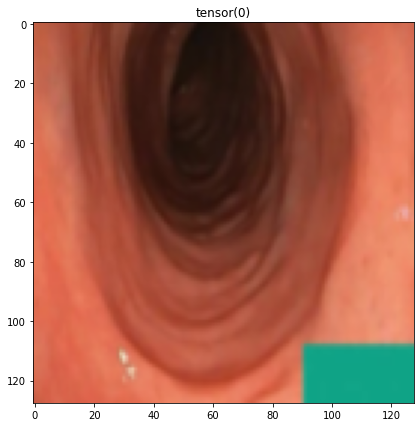

In [48]:
train_dl, valid_dl = get_data(config, df_anno, df_unanno, is_visual=True)

In [51]:
model = timm.create_model(config.MODEL.NAME, pretrained=True, num_classes = 2)

In [1]:
# model

In [54]:
fts.shape

torch.Size([8, 2048])

In [52]:
features = []
gts = []
for x, y in tqdm(train_dl):
    fts = backbone(x)
    features += fts
    gts += y

  9%|█████▌                                                      | 98/1067 [03:15<32:16,  2.00s/it]


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 8388608 bytes.

In [12]:
model = build_model(config)

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
if config.TRAIN.IS_SSL:
    classifier = SemiSupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)

In [15]:
# for x, y in train_dl:
#     break
# model(x)

In [16]:
# classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_resnet50\\05_31_2022_17_33_39_ce.pth')

In [17]:
classifier.fit()

Training epoch: 1 | Current LR: 0.000050


  0%|▏                                                 | 3/1000 [00:07<44:08,  2.66s/it, loss=2.54]


KeyboardInterrupt: 

In [ ]:
# classifier.save_checkpoint('./')